In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from cycler import cycler

##### Option Valuation Model (BSM) prior to expiration (t<T)
# https://www.simtrade.fr/blog_simtrade/black-scholes-merton-option-pricing-model/
# under following assumptions:
# - The model considers European options, which can only be exercised at their expiration date.
# - The price of the underlying asset follows a geometric Brownian motion (corresponding to log-normal distribution for the price at a given point in time).
# - The risk-free rate remains constant over time until the expiration date.
# - The volatility of the underlying asset price remains constant over time until the expiration date.
# - There are no dividend payments on the underlying asset.
# - There are no transaction costs on the underlying asset.
# - There are no arbitrage opportunities.

def d1(S, X, r, stdev, T): # Delta on Call option, (1 - norm.cdf(d1)) = Delta on Put option
    return (np.log(S / X) + (r + (stdev ** 2) / 2) * T) / (stdev * np.sqrt(T))

# d2 = d1 - stdev * np.sqrt(T)
def d2(S, X, r, stdev, T):
    return (np.log(S / X) + (r - (stdev ** 2) / 2) * T) / (stdev * np.sqrt(T))

def BSM_Call(S, X, r, T, d1, d2):
    return (S * norm.cdf(d1)) - (X * np.exp(-r * T) * norm.cdf(d2))
    
def BSM_Put(S, X, r, T, d1, d2):
    return (X * np.exp(-r * T) * norm.cdf(-d2)) - (S * norm.cdf(-d1))
    #return (X * np.exp(-r * T) * (1 - norm.cdf(d2))) - (S * (1 - norm.cdf(d1)))

##### Option Payoff Functions at maturity (t=T)
def Long_Stock(S, buy_price, N):
    return (S - buy_price) * N, buy_price # (Payoff, Break Even Point)

def Short_Stock(S, buy_price, N):
    return -(S - buy_price) * N, buy_price # (Payoff, Break Even Point)

def Long_ZCB(S, X):
    return [X] * len(S) # X = Zero Coupon Bond Par Value

def Short_ZCB(S, X):
    return [-X] * len(S) # X = Zero Coupon Bond Par Value

def Long_Call(S, X, N, option_premium):
    return list(map(lambda s: (max(0, s-X) - option_premium) * N, S)), X+option_premium # (Payoff, Break Even Point)

def Short_Call(S, X, N, option_premium):
    return list(map(lambda s: -(max(0, s-X) - option_premium) * N, S)), X+option_premium # (Payoff, Break Even Point)

def Long_Put(S, X, N, option_premium):
    return list(map(lambda s: (max(0, X-s) - option_premium) * N, S)), X-option_premium # (Payoff, Break Even Point)

def Short_Put(S, X, N, option_premium):
    return list(map(lambda s: -(max(0, X-s) - option_premium) * N, S)), X-option_premium # (Payoff, Break Even Point)

def graph_payoffs(selected_positions, S, ):
    
    fig,ax = plt.subplots(figsize=(6,8), dpi=100)
    for position in selected_positions:

        plt.plot(payoff_df[position], label=position)
        
        # if multiple 0s in option payoff e.g. when option premium = 0
        if payoff_df[position].isin([0]).sum() > 1: 
            # if Long Call or Short Call: BEP is the LAST S that makes Option Payoff = 0
            if 'Call' in position:
                BEP = payoff_df[position][payoff_df[position] == 0].index[-1]
                print(f'{position} BEP: S = {BEP}')
                plt.scatter(x=BEP, y=0, marker='o', s=100, c='dodgerblue')

            # if Long Put or Short Put: BEP is the FIRST S that makes Option Payoff = 0
            elif 'Put' in position:
                BEP = payoff_df[position][payoff_df[position] == 0].index[0]
                print(f'{position} BEP: S = {BEP}')
                plt.scatter(x=BEP, y=0, marker='o', s=100, c='dodgerblue')
        
        elif payoff_df[position].isin([0]).sum() > 0: 
            BEP = payoff_df[position][payoff_df[position] == 0].index
            print(f'{position} BEP: S = {BEP[0]}')
            plt.scatter(x=BEP, y=0, marker='o', s=100, c='dodgerblue')

    # Graph Synthetic Position
    if 'Synthetic Position' in payoff_df.columns:
        plt.plot(payoff_df['Synthetic Position'], label='Synthetic Position', linestyle='--', linewidth=3)

        if payoff_df['Synthetic Position'].isin([0]).sum() == 2: # Two 0s in Option Payoff e.g. Straddle (Two BEPs)
            BEP_PF_lst = list(payoff_df['Synthetic Position'][payoff_df['Synthetic Position'].isin([0])].index)
            print(f'Synthetic Position BEP: S = {BEP_PF_lst}')
            for BEP_PF in BEP_PF_lst:
                plt.scatter(x=BEP_PF, y=0, marker='v', s=100, c='tab:red')        

        elif payoff_df['Synthetic Position'].isin([0]).sum() > 1: # More than one 0s in Option Payoff (Many BEPs)
            lagged_comparison = payoff_df['Synthetic Position'] == payoff_df['Synthetic Position'].shift(-1).replace(np.nan)
            BEP_PF = lagged_comparison.where(lagged_comparison == True).first_valid_index()
            print(f'Synthetic Position BEP: S = {BEP_PF}')
            plt.scatter(x=BEP_PF, y=0, marker='v', s=100, c='tab:red')

        elif payoff_df['Synthetic Position'].isin([0]).sum() > 0: # If any 0s in Option Payoff (BEP exist)
            BEP_PF = payoff_df['Synthetic Position'][payoff_df['Synthetic Position'] == 0].index
            print(f'Synthetic Position BEP: S = {BEP_PF[0]}')
            plt.scatter(x=BEP_PF, y=0, marker='v', s=100, c='tab:red')    

    # fix graph scale
    ax.set_xlim(0,max(S))
    yscale = payoff_df.max(axis=0).max()
    ax.set_ylim(-yscale,yscale)
    
    # Move bottom x-axis to centre, passing through (0,0)
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    ax.set_xlabel('Spot price at Expiration(t=T)', loc='right')
    ax.set_ylabel('Payoff at Expiration')

    fig.legend();

# Option Valuation Factors

In [427]:
# Generate Current Spot Price (S)
data_points = 200
S = np.arange(0, data_points+1, 5)
payoff_df = pd.DataFrame(index = S)
payoff_df.index.name = 'Spot'

In [428]:
### BSM Inputs
# Excercise Price
X = 100
# continuously compounded Risk-free rate (annualized), assumed 4% 
r = 0.04
# Expected Volatility of spot asset returns until expiration date (annualized), assumed 20% 
stdev = 0.2
# (T - t)/T = 0.75 (9 months remaining to expiration date), remaining time to expiration in years 
T = 0.75

# Generate BSM option premium valuations prior to Maturity
d_1 = d1(S, X, r, stdev, T)
d_2 = d2(S, X, r, stdev, T)
# BSM Call Option
BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
payoff_df['Long_Call_BSM'] = BSM_Call_payoff
# BSM Put Option
BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
payoff_df['Long_Put_BSM'] = BSM_Put_payoff


### Maturity Payoff Inputs
# Option premium
option_premium = 0
# Number of underlying assets under Option Contract 
N = 1

# Call Option Payoff at Expiration
Long_Call_payoff, Long_Call_BEP = Long_Call(S, X, N, option_premium)
payoff_df['Long_Call'] = Long_Call_payoff
# Call Option Payoff at Expiration
Long_Put_payoff, Long_Put_BEP = Long_Put(S, X, N, option_premium)
payoff_df['Long_Put'] = Long_Put_payoff

Long_Call_BSM BEP: S = 0
Long_Call BEP: S = 100


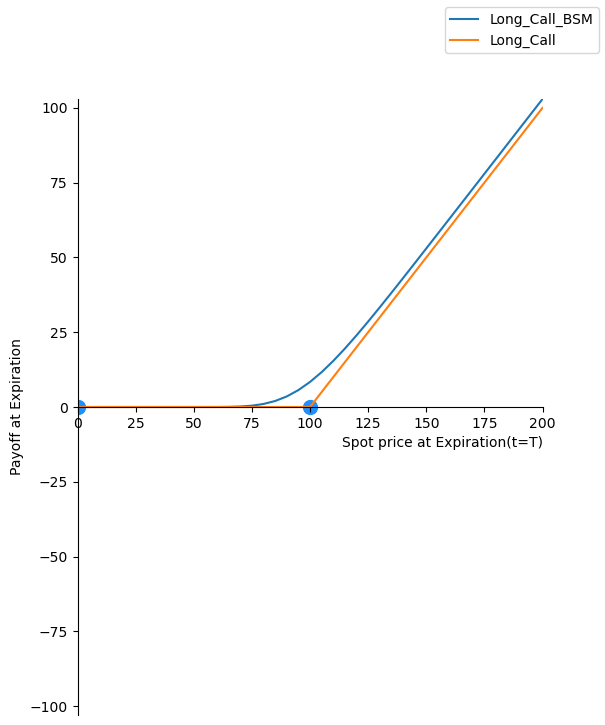

In [429]:
# Call Option Payoff at Maturity and prior to Maturity(BSM)
# Same Exercise Price(X), different time to maturity
selected_positions = ['Long_Call_BSM', 'Long_Call']
graph_payoffs(selected_positions, S)

Long_Put BEP: S = 100


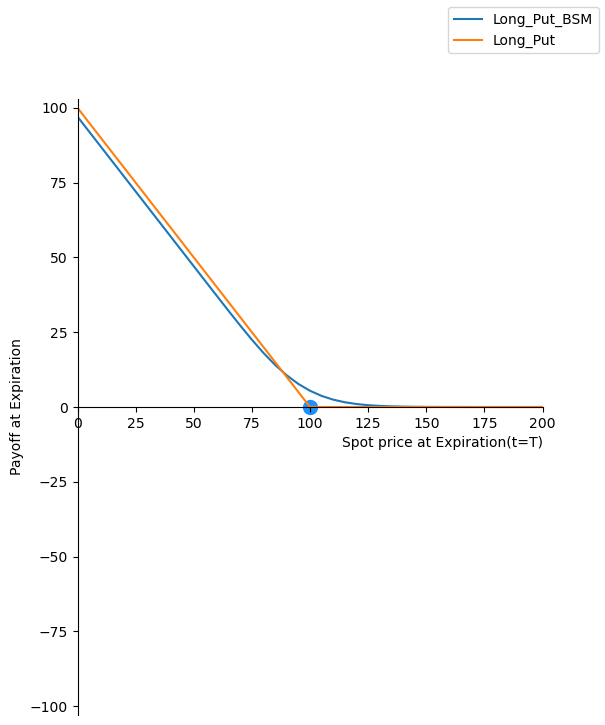

In [430]:
# Put Option Payoff at Maturity and prior to Maturity(BSM)
# Same Exercise Price(X), different time to maturity
selected_positions = ['Long_Put_BSM', 'Long_Put']
graph_payoffs(selected_positions, S)

In [431]:
# Call OTM, Put ITM
payoff_df.iloc[10]

Long_Call_BSM     0.000181
Long_Put_BSM     47.044735
Long_Call         0.000000
Long_Put         50.000000
Name: 50, dtype: float64

In [432]:
# Put & Call S = X (ATM)
payoff_df.iloc[20]

Long_Call_BSM    8.378469
Long_Put_BSM     5.423022
Long_Call        0.000000
Long_Put         0.000000
Name: 100, dtype: float64

In [433]:
# Call ITM, Put OTM
payoff_df.iloc[30]

Long_Call_BSM    52.995402
Long_Put_BSM      0.039955
Long_Call        50.000000
Long_Put          0.000000
Name: 150, dtype: float64

In [434]:
# Option value's sensitivity to inputs
# https://demonstrations.wolfram.com/StandardAmericanAndEuropeanOptions/

### Sensitivity to Time (Theta)

Option Value = Intrinsic Value (Profit Status: ITM, ATM, OTM) + Time Value
Time Value increases with longer time left to maturity, reflecting higher probability of spot price increase above strike price at expiration
Stock price has theoretically unlimited upside, longer time left with given volatility makes it more likely to end up ITM at expiration


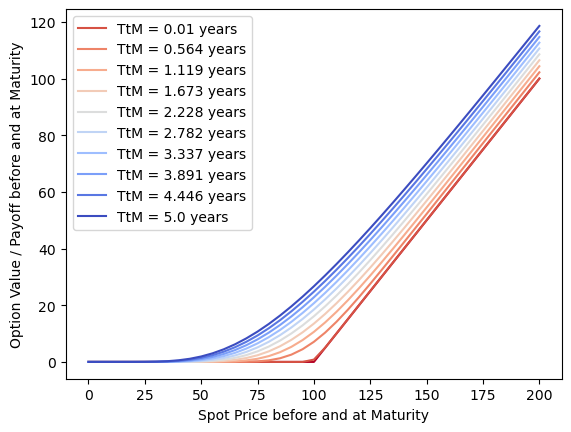

In [435]:
### Call

# Risk-free rate
r = 0.04
# Volatility
stdev = 0.2
# (T - t), remaining time to expiration in years
TtM_variation = np.linspace(0.01,5,10)

fig,ax = plt.subplots()
custom_cycler = (cycler(color = plt.cm.coolwarm_r(np.linspace(0,1,len(TtM_variation)+1))))
ax.set_prop_cycle(custom_cycler)
plt.plot(S, Long_Call_payoff)
for t in TtM_variation:
    T = t
    d_1 = d1(S, X, r, stdev, T)
    d_2 = d2(S, X, r, stdev, T)
    BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
    BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
    plt.plot(S, BSM_Call_payoff, label=f'TtM = {round(t,3)} years')

plt.ylabel('Option Value / Payoff before and at Maturity')
plt.xlabel('Spot Price before and at Maturity')
plt.legend();
print('Option Value = Intrinsic Value (Profit Status: ITM, ATM, OTM) + Time Value')
print('Time Value increases with longer time left to maturity, reflecting higher probability of spot price increase above strike price at expiration')
print('Stock price has theoretically unlimited upside, longer time left with given volatility makes it more likely to end up ITM at expiration')

Longer time to maturity increases time value of put option value, reflecting higher probability of the option ending up ITM at expiration
However, stock price is bound by 0, asset price cannot fall negative, limiting maximum upside of put option to when asset price falls to 0 (rare in reality)
Due to limited upside when put option is at Deep ITM, time value of DITM put option is negative, reducing the put option value
This reflects that DITM European put option can move away from DITM given sufficient time to maturity and volatility


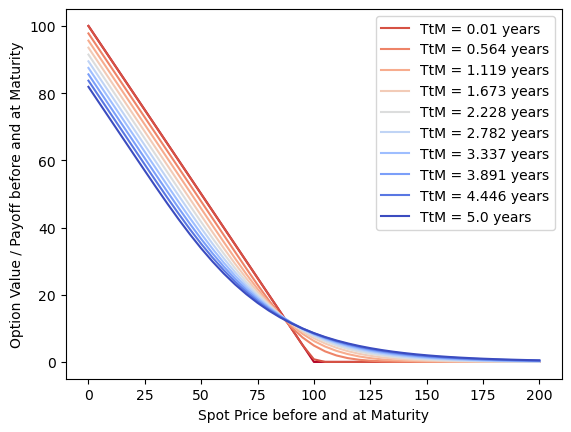

In [436]:
### Put

### Sensitivity to Time
fig,ax = plt.subplots()
custom_cycler = (cycler(color = plt.cm.coolwarm_r(np.linspace(0,1,len(TtM_variation)+1))))
ax.set_prop_cycle(custom_cycler)
plt.plot(S, Long_Put_payoff)
for t in TtM_variation:
    T = t
    d_1 = d1(S, X, r, stdev, T)
    d_2 = d2(S, X, r, stdev, T)
    BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
    BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
    plt.plot(S, BSM_Put_payoff, label=f'TtM = {round(t,3)} years')
    
plt.ylabel('Option Value / Payoff before and at Maturity')
plt.xlabel('Spot Price before and at Maturity')
plt.legend();
print('Longer time to maturity increases time value of put option value, reflecting higher probability of the option ending up ITM at expiration')
print('However, stock price is bound by 0, asset price cannot fall negative, limiting maximum upside of put option to when asset price falls to 0 (rare in reality)')
print('Due to limited upside when put option is at Deep ITM, time value of DITM put option is negative, reducing the put option value')
print('This reflects that DITM European put option can move away from DITM given sufficient time to maturity and volatility')


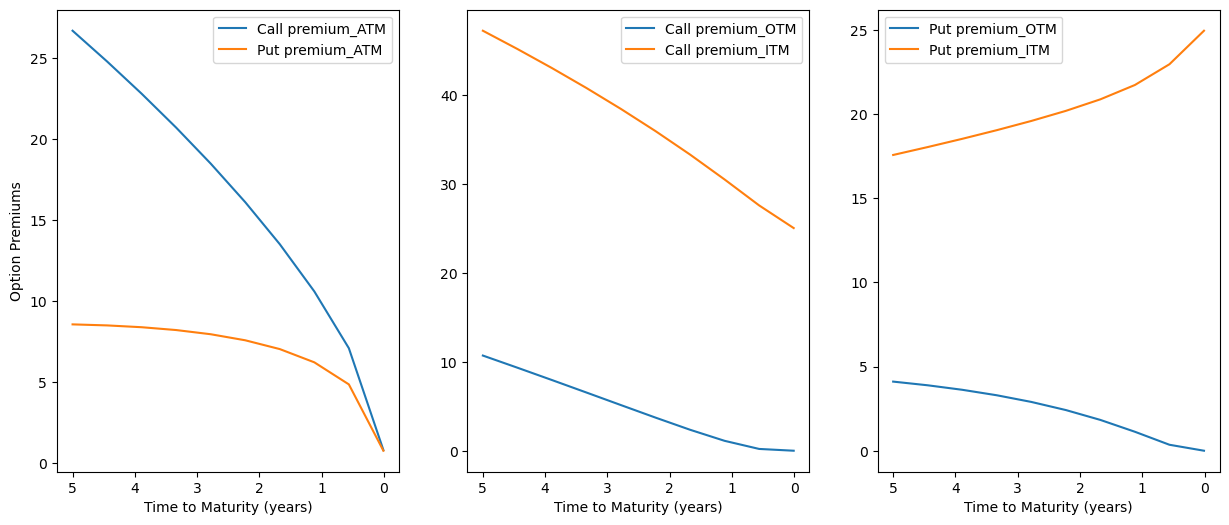

In [437]:
def Theta_Call(S, X, r, stdev, TtM_variation, nth_premium=20):
    BSM_C = []
    for t in TtM_variation:
        T = t
        d_1 = d1(S, X, r, stdev, T)
        d_2 = d2(S, X, r, stdev, T)
        BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
        BSM_C.append(BSM_Call_payoff[nth_premium])
    return BSM_C
        
def Theta_Put(S, X, r, stdev, TtM_variation, nth_premium=20):
    BSM_P = []
    for t in TtM_variation:
        T = t
        d_1 = d1(S, X, r, stdev, T)
        d_2 = d2(S, X, r, stdev, T)
        BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
        BSM_P.append(BSM_Put_payoff[nth_premium])
    return BSM_P

nth_premium = 20 # option premium at Break Even Point above ATM: S = X (Exercise price)
Theta_C = pd.DataFrame(zip(TtM_variation, Theta_Call(S, X, r, stdev, TtM_variation, nth_premium)), columns = ['Time to Maturity', 'Call premium_ATM'])
Theta_P = pd.DataFrame(zip(TtM_variation, Theta_Put(S, X, r, stdev, TtM_variation, nth_premium)), columns = ['Time to Maturity', 'Put premium_ATM'])

Theta_C.index = Theta_C['Time to Maturity']
Theta_P.index = Theta_P['Time to Maturity']

nth_premium = 15 # Call OTM, Put ITM
Theta_C['Call premium_OTM'] = Theta_Call(S, X, r, stdev, TtM_variation, nth_premium)
Theta_P['Put premium_ITM'] = Theta_Put(S, X, r, stdev, TtM_variation, nth_premium)

nth_premium = 25 # Call ITM, Put OTM
Theta_C['Call premium_ITM'] = Theta_Call(S, X, r, stdev, TtM_variation, nth_premium)
Theta_P['Put premium_OTM'] = Theta_Put(S, X, r, stdev, TtM_variation, nth_premium)

fig,ax = plt.subplots(1,3, figsize=(15,6))
ax[0].plot(Theta_C['Call premium_ATM'], label='Call premium_ATM')
ax[0].plot(Theta_P['Put premium_ATM'], label='Put premium_ATM')
ax[0].set_xlim(ax[0].get_xlim()[::-1])

ax[1].plot(Theta_C['Call premium_OTM'], label='Call premium_OTM')
ax[1].plot(Theta_C['Call premium_ITM'], label='Call premium_ITM')
ax[1].set_xlim(ax[1].get_xlim()[::-1])

ax[2].plot(Theta_P['Put premium_OTM'], label='Put premium_OTM')
ax[2].plot(Theta_P['Put premium_ITM'], label='Put premium_ITM')
ax[2].set_xlim(ax[2].get_xlim()[::-1])

ax[0].set_ylabel('Option Premiums')
ax[0].set_xlabel('Time to Maturity (years)')
ax[1].set_xlabel('Time to Maturity (years)')
ax[2].set_xlabel('Time to Maturity (years)')
ax[0].legend()
ax[1].legend()
ax[2].legend();

higher volatility, higher probability of ending up ITM, increasing time value of the option premium
higher volatility always benefits the option holder, as option holder can exercise option for the part of volatility that benefits them


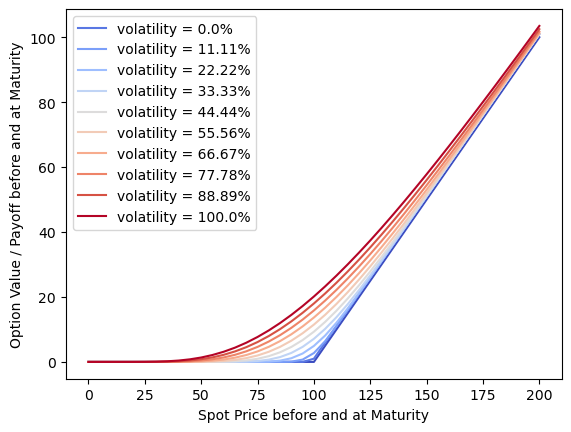

In [438]:
### Sensitivity to Volatility
# Risk-free rate
r = 0.04
# Volatility
vol_variation = np.linspace(0,1,10)
# (T - t), remaining time to expiration in years
T = 0.25

fig,ax = plt.subplots()
custom_cycler = (cycler(color = plt.cm.coolwarm(np.linspace(0,1,len(vol_variation)+1))))
ax.set_prop_cycle(custom_cycler)
plt.plot(S, Long_Call_payoff)
for vol in vol_variation:
    stdev = vol
    d_1 = d1(S, X, r, stdev, T)
    d_2 = d2(S, X, r, stdev, T)
    BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
    BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
    plt.plot(S, BSM_Call_payoff, label=f'volatility = {round(vol*100,2)}%')

plt.ylabel('Option Value / Payoff before and at Maturity')
plt.xlabel('Spot Price before and at Maturity')
plt.legend();
print('higher volatility, higher probability of ending up ITM, increasing time value of the option premium')
print('higher volatility always benefits the option holder, as option holder can exercise option for the part of volatility that benefits them')

higher volatility, higher option premium


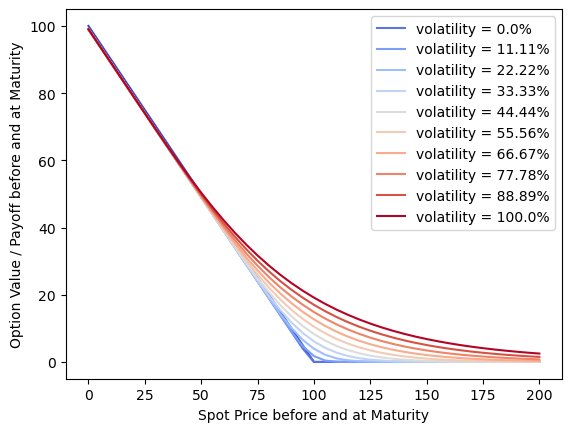

In [439]:
### Sensitivity to Volatility
fig,ax = plt.subplots()
custom_cycler = (cycler(color = plt.cm.coolwarm(np.linspace(0,1,len(vol_variation)+1))))
ax.set_prop_cycle(custom_cycler)
plt.plot(S, Long_Put_payoff)
for vol in vol_variation:
    stdev = vol
    d_1 = d1(S, X, r, stdev, T)
    d_2 = d2(S, X, r, stdev, T)
    BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
    BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
    plt.plot(S, BSM_Put_payoff, label=f'volatility = {round(vol*100,2)}%')

plt.ylabel('Option Value / Payoff before and at Maturity')
plt.xlabel('Spot Price before and at Maturity')    
plt.legend();
print('higher volatility, higher option premium')

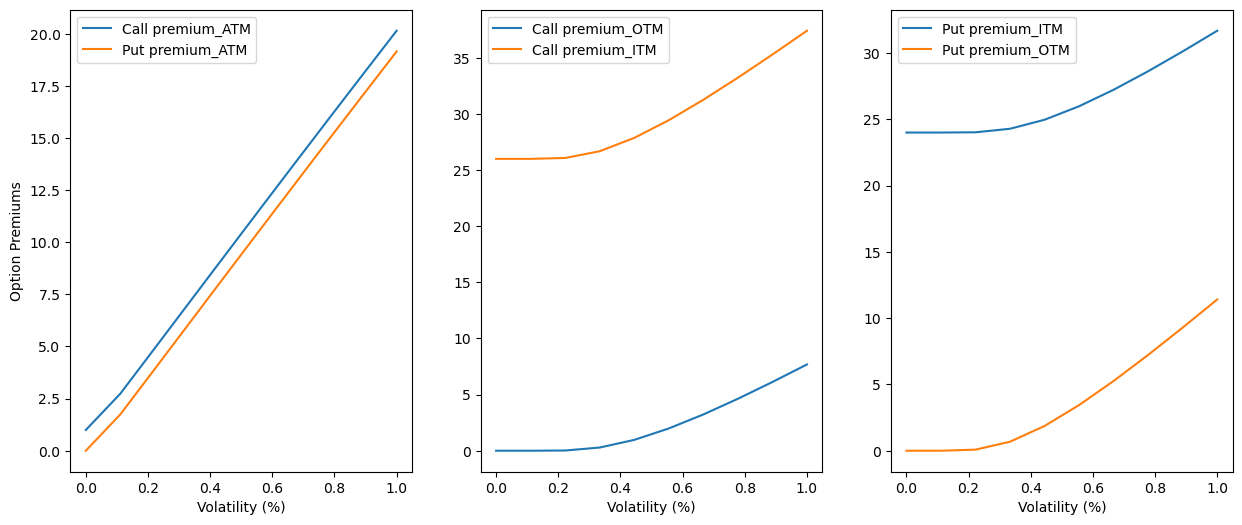

In [440]:
def Vega_Call(S, X, r, T, vol_variation, nth_premium=20):
    BSM_C = []
    for vol in vol_variation:
        stdev = vol
        d_1 = d1(S, X, r, stdev, T)
        d_2 = d2(S, X, r, stdev, T)
        BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
        BSM_C.append(BSM_Call_payoff[nth_premium])
    return BSM_C
        
def Vega_Put(S, X, r, T, vol_variation, nth_premium=20):
    BSM_P = []
    for vol in vol_variation:
        stdev = vol
        d_1 = d1(S, X, r, stdev, T)
        d_2 = d2(S, X, r, stdev, T)
        BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
        BSM_P.append(BSM_Put_payoff[nth_premium])
    return BSM_P

nth_premium = 20 # option premium at Break Even Point above ATM: S = X (Exercise price)
Vega_C = pd.DataFrame(zip(vol_variation, Vega_Call(S, X, r, T, vol_variation, nth_premium)), columns = ['Volatility', 'Call premium_ATM'])
Vega_P = pd.DataFrame(zip(vol_variation, Vega_Put(S, X, r, T, vol_variation, nth_premium)), columns = ['Volatility', 'Put premium_ATM'])

Vega_C.index = Vega_C['Volatility']
Vega_P.index = Vega_P['Volatility']

nth_premium = 15 # Call OTM, Put ITM
Vega_C['Call premium_OTM'] = Vega_Call(S, X, r, T, vol_variation, nth_premium)
Vega_P['Put premium_ITM'] = Vega_Put(S, X, r, T, vol_variation, nth_premium)

nth_premium = 25 # Call ITM, Put OTM
Vega_C['Call premium_ITM'] = Vega_Call(S, X, r, T, vol_variation, nth_premium)
Vega_P['Put premium_OTM'] = Vega_Put(S, X, r, T, vol_variation, nth_premium)

fig,ax = plt.subplots(1,3, figsize=(15,6))
ax[0].plot(Vega_C['Call premium_ATM'], label='Call premium_ATM')
ax[0].plot(Vega_P['Put premium_ATM'], label='Put premium_ATM')

ax[1].plot(Vega_C['Call premium_OTM'], label='Call premium_OTM')
ax[1].plot(Vega_C['Call premium_ITM'], label='Call premium_ITM')

ax[2].plot(Vega_P['Put premium_ITM'], label='Put premium_ITM')
ax[2].plot(Vega_P['Put premium_OTM'], label='Put premium_OTM')

ax[0].set_ylabel('Option Premiums')
ax[0].set_xlabel('Volatility (%)')
ax[1].set_xlabel('Volatility (%)')
ax[2].set_xlabel('Volatility (%)')
ax[0].legend()
ax[1].legend()
ax[2].legend();

higher interest rate, higher interest rates increase call premiums
Long calls give the right to purchase stock, normally the cost of that right is less than the fully exercisable value
The difference of those two numbers could be deposited into an interest bearing account


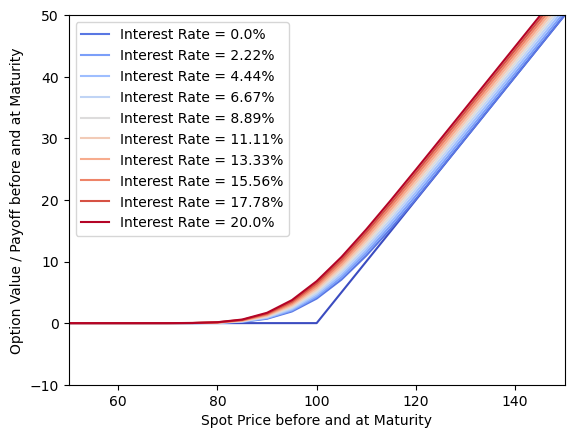

In [441]:
### Sensitivity to Interest Rate
# Risk-free rate
Rf_variation = np.linspace(0,0.20,10)
# Volatility
stdev = 0.2
# (T - t), remaining time to expiration in years
T = 0.25

fig,ax = plt.subplots()
custom_cycler = (cycler(color = plt.cm.coolwarm(np.linspace(0,1,len(Rf_variation)+1))))
ax.set_prop_cycle(custom_cycler)
plt.plot(S, Long_Call_payoff)
for Rf in Rf_variation:
    r = Rf
    d_1 = d1(S, X, r, stdev, T)
    d_2 = d2(S, X, r, stdev, T)
    BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
    BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
    plt.plot(S, BSM_Call_payoff, label=f'Interest Rate = {round(r*100,2)}%')

plt.xlim(50,150)
plt.ylim(-10,50)
plt.ylabel('Option Value / Payoff before and at Maturity')
plt.xlabel('Spot Price before and at Maturity')
plt.legend();
print('higher interest rate, higher interest rates increase call premiums')
print('Long calls give the right to purchase stock, normally the cost of that right is less than the fully exercisable value')
print('The difference of those two numbers could be deposited into an interest bearing account')

With an increase in interest rates, shorting stock becomes more profitable than buying puts
as the spot asset generates income and the put option incurs initial cash outlay
Thus, put option prices are impacted negatively by increasing interest rates


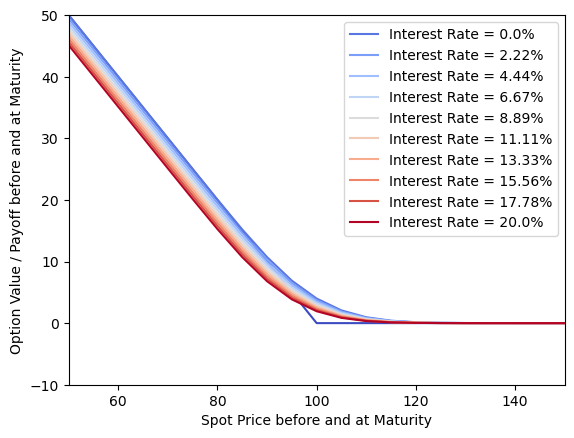

In [442]:
### Sensitivity to Interest Rate
fig,ax = plt.subplots()
custom_cycler = (cycler(color = plt.cm.coolwarm(np.linspace(0,1,len(Rf_variation)+1))))
ax.set_prop_cycle(custom_cycler)
plt.plot(S, Long_Put_payoff)
for Rf in Rf_variation:
    r = Rf
    d_1 = d1(S, X, r, stdev, T)
    d_2 = d2(S, X, r, stdev, T)
    BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
    BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
    plt.plot(S, BSM_Put_payoff, label=f'Interest Rate = {round(r*100,2)}%')

plt.xlim(50,150)
plt.ylim(-10,50)   
plt.ylabel('Option Value / Payoff before and at Maturity')
plt.xlabel('Spot Price before and at Maturity')
plt.legend();
print('With an increase in interest rates, shorting stock becomes more profitable than buying puts')
print('as the spot asset generates income and the put option incurs initial cash outlay')
print('Thus, put option prices are impacted negatively by increasing interest rates')

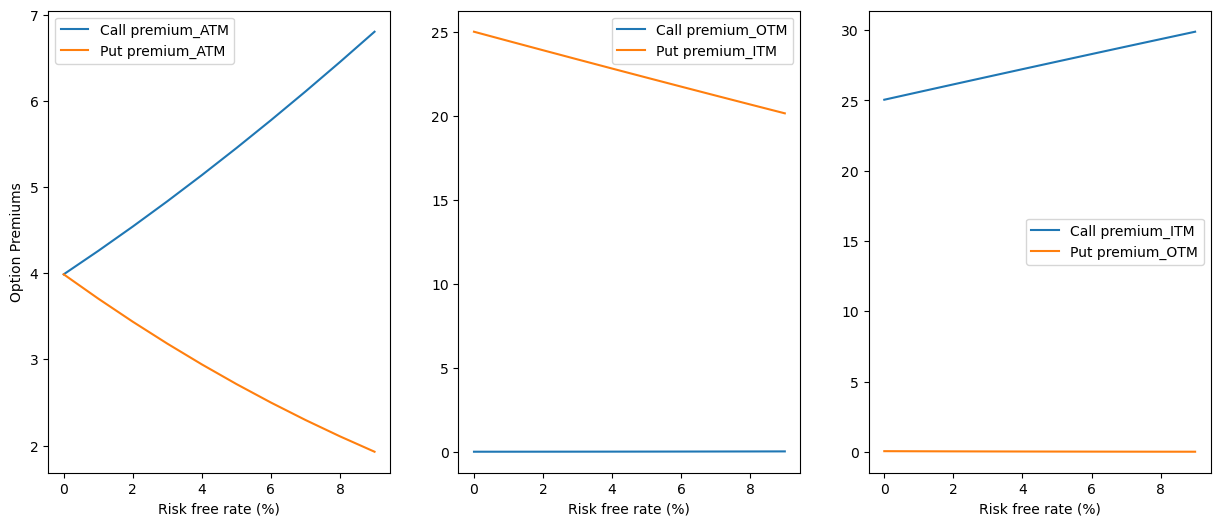

In [443]:
def Rho_Call(S, X, stdev, T, Rf_variation, nth_premium=20):
    BSM_C = []
    for Rf in Rf_variation:
        r = Rf
        d_1 = d1(S, X, r, stdev, T)
        d_2 = d2(S, X, r, stdev, T)
        BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
        BSM_C.append(BSM_Call_payoff[nth_premium])
    return BSM_C
        
def Rho_Put(S, X, stdev, T, Rf_variation, nth_premium=20):
    BSM_P = []
    for Rf in Rf_variation:
        r = Rf
        d_1 = d1(S, X, r, stdev, T)
        d_2 = d2(S, X, r, stdev, T)
        BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
        BSM_P.append(BSM_Put_payoff[nth_premium])
    return BSM_P

nth_premium = 20 # option premium at Break Even Point above ATM: S = X (Exercise price)
Rho_C = pd.DataFrame(zip(Rf_variation, Rho_Call(S, X, stdev, T, Rf_variation, nth_premium)), columns = ['Risk free rate', 'Call premium_ATM'])
Rho_P = pd.DataFrame(zip(Rf_variation, Rho_Put(S, X, stdev, T, Rf_variation, nth_premium)), columns = ['Risk free rate', 'Put premium_ATM'])

nth_premium = 15 # Call OTM, Put ITM
Rho_C['Call premium_OTM'] = Rho_Call(S, X, stdev, T, Rf_variation, nth_premium)
Rho_P['Put premium_ITM'] = Rho_Put(S, X, stdev, T, Rf_variation, nth_premium)

nth_premium = 25 # Call ITM, Put OTM
Rho_C['Call premium_ITM'] = Rho_Call(S, X, stdev, T, Rf_variation, nth_premium)
Rho_P['Put premium_OTM'] = Rho_Put(S, X, stdev, T, Rf_variation, nth_premium)

fig,ax = plt.subplots(1,3, figsize=(15,6))
ax[0].plot(Rho_C['Call premium_ATM'], label='Call premium_ATM')
ax[0].plot(Rho_P['Put premium_ATM'], label='Put premium_ATM')

ax[1].plot(Rho_C['Call premium_OTM'], label='Call premium_OTM')
ax[1].plot(Rho_P['Put premium_ITM'], label='Put premium_ITM')

ax[2].plot(Rho_C['Call premium_ITM'], label='Call premium_ITM')
ax[2].plot(Rho_P['Put premium_OTM'], label='Put premium_OTM')

ax[0].set_ylabel('Option Premiums')
ax[0].set_xlabel('Risk free rate (%)')
ax[1].set_xlabel('Risk free rate (%)')
ax[2].set_xlabel('Risk free rate (%)')
ax[0].legend()
ax[1].legend()
ax[2].legend();

lower strike price, higher probability that call option will be ITM, call option premium increases


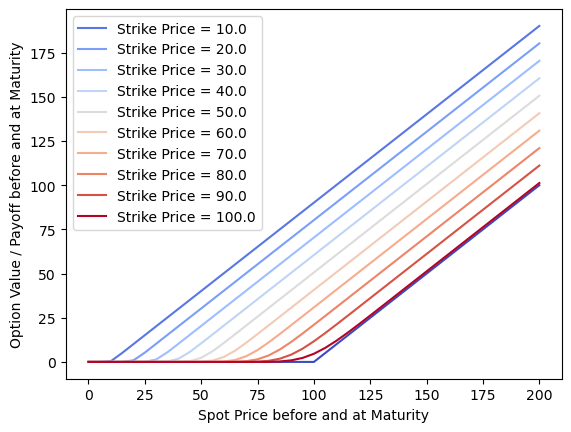

In [444]:
### Variation in Excercise Price
X_C_variation = np.linspace(10,100,10)

# Risk-free rate
r = 0.05
# Volatility
stdev = 0.2
# (T - t), remaining time to expiration in years
T = 0.25

fig,ax = plt.subplots()
custom_cycler = (cycler(color = plt.cm.coolwarm(np.linspace(0,1,len(X_C_variation)+1))))
ax.set_prop_cycle(custom_cycler)
plt.plot(S, Long_Call_payoff)
for K in X_C_variation:
    X = K
    d_1 = d1(S, X, r, stdev, T)
    d_2 = d2(S, X, r, stdev, T)
    BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
    BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
    plt.plot(S, BSM_Call_payoff, label=f'Strike Price = {round(K,0)}')

plt.ylabel('Option Value / Payoff before and at Maturity')
plt.xlabel('Spot Price before and at Maturity')
plt.legend();
print('lower strike price, higher probability that call option will be ITM, call option premium increases')

lower the strike price, lower probability of put option ITM, lower option premium


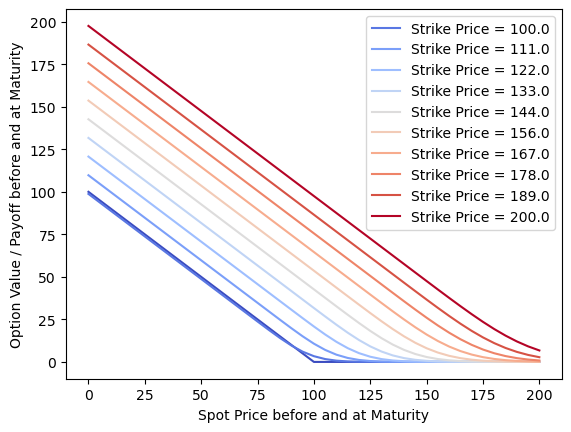

In [445]:
### Variation in Excercise Price
X_P_variation = np.linspace(100,200,10)

fig,ax = plt.subplots()
custom_cycler = (cycler(color = plt.cm.coolwarm(np.linspace(0,1,len(X_P_variation)+1))))
ax.set_prop_cycle(custom_cycler)
plt.plot(S, Long_Put_payoff)
for K in X_P_variation:
    X = K
    d_1 = d1(S, X, r, stdev, T)
    d_2 = d2(S, X, r, stdev, T)
    BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
    BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
    plt.plot(S, BSM_Put_payoff, label=f'Strike Price = {round(K,0)}')

plt.ylabel('Option Value / Payoff before and at Maturity')
plt.xlabel('Spot Price before and at Maturity')
plt.legend();
print('lower the strike price, lower probability of put option ITM, lower option premium')

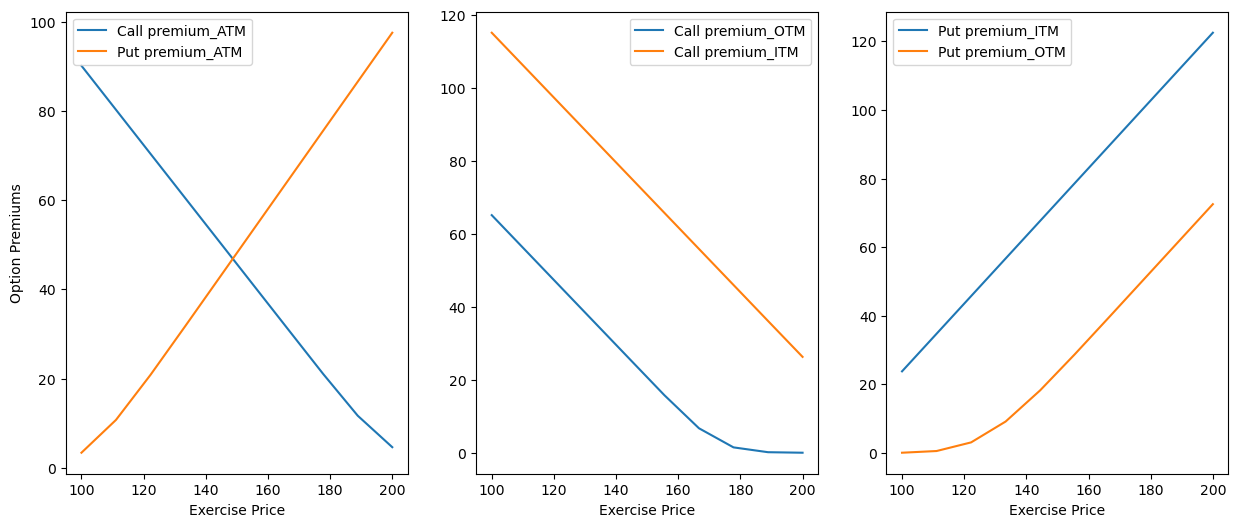

In [446]:
def X_Call(S, X, r, stdev, T, X_C_variation, nth_premium=20):
    BSM_C = []
    for K in X_C_variation:
        X = K
        d_1 = d1(S, X, r, stdev, T)
        d_2 = d2(S, X, r, stdev, T)
        BSM_Call_payoff = BSM_Call(S, X, r, T, d1=d_1, d2=d_2)
        BSM_C.append(BSM_Call_payoff[nth_premium])
    return BSM_C
        
def X_Put(S, X, r, stdev, T, X_P_variation, nth_premium=20):
    BSM_P = []
    for K in X_P_variation:
        X = K
        d_1 = d1(S, X, r, stdev, T)
        d_2 = d2(S, X, r, stdev, T)
        BSM_Put_payoff = BSM_Put(S, X, r, T, d1=d_1, d2=d_2)
        BSM_P.append(BSM_Put_payoff[nth_premium])
    return BSM_P

nth_premium = 20 # option premium at Break Even Point above ATM: S = X (Exercise price)
X_C = pd.DataFrame(zip(X_variation, X_Call(S, X, r, stdev, T, X_C_variation, nth_premium)), columns = ['Exercise Price', 'Call premium_ATM'])
X_P = pd.DataFrame(zip(X_variation, X_Put(S, X, r, stdev, T, X_P_variation, nth_premium)), columns = ['Exercise Price', 'Put premium_ATM'])

X_C.index = X_C['Exercise Price']
X_P.index = X_P['Exercise Price']

nth_premium = 15 # Call OTM, Put ITM
X_C['Call premium_OTM'] = X_Call(S, X, r, stdev, T, X_C_variation, nth_premium)
X_P['Put premium_ITM'] = X_Put(S, X, r, stdev, T, X_P_variation, nth_premium)

nth_premium = 25 # Call ITM, Put OTM
X_C['Call premium_ITM'] = X_Call(S, X, r, stdev, T, X_C_variation, nth_premium)
X_P['Put premium_OTM'] = X_Put(S, X, r, stdev, T, X_P_variation, nth_premium)

fig,ax = plt.subplots(1,3, figsize=(15,6))
ax[0].plot(X_C['Call premium_ATM'], label='Call premium_ATM')
ax[0].plot(X_P['Put premium_ATM'], label='Put premium_ATM')

ax[1].plot(X_C['Call premium_OTM'], label='Call premium_OTM')
ax[1].plot(X_C['Call premium_ITM'], label='Call premium_ITM')

ax[2].plot(X_P['Put premium_ITM'], label='Put premium_ITM')
ax[2].plot(X_P['Put premium_OTM'], label='Put premium_OTM')

ax[0].set_ylabel('Option Premiums')
ax[0].set_xlabel('Exercise Price')
ax[1].set_xlabel('Exercise Price')
ax[2].set_xlabel('Exercise Price')
ax[0].legend()
ax[1].legend()
ax[2].legend();